Imports and setting global seed:

In [19]:
%pip install lightning_lite
import numpy as np
import anndata as ad
import pandas as pd
import torch
from lightning_lite import seed_everything
from pytorch_lightning.callbacks import EarlyStopping  # ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

seed_everything(10, workers=True)

Global seed set to 10


Note: you may need to restart the kernel to use updated packages.


10

Hyperparameters:

In [44]:
final_num_epochs=50
final_lr=0.003
final_hidden_size=100
final_batch_size=32

Loading data from path, converting objs to a dataframe for analysis and prediction task

In [20]:
path="C:/Users/miria/OneDrive/Documents/AMatematyka/aaaaDL4LS/DL4LS24-IDK-main/data/train/cell_data.h5ad"
### input Your path

anndata = ad.read_h5ad(path)
anndata.layers
anndata.X = anndata.layers['exprs'] # FIX!

df=anndata.obs
counts=anndata.layers['counts']
exprs=anndata.layers['exprs']

Appending information from counts and exprs to dataframe for prediction task

In [21]:

list_cols_exprs=['exprs'+str(i) for i in range(40)]

df_exprs = pd.DataFrame(data=exprs, columns=list_cols_exprs,index=df.index)

In [22]:
result = pd.concat([df, df_exprs], axis=1)

print(result.shape)
df=result.copy()

(236791, 79)


Data preprocessing; 
1. Remove unneccesary columns 
2. One-hot encode categorical ones 
3. End up with only float values

In [23]:
print("All columns: ",df.columns)
int_columns = df.select_dtypes(include='int').columns.tolist()
df[int_columns] = df[int_columns].astype(float)

non_float_columns = df.select_dtypes(exclude='float').columns.tolist()
'''for column in non_float_columns:
    print(f"{column}: {df[column].dtype}")'''
category_columns = df.select_dtypes(include='category').columns.tolist()
print(df['sample_id'].equals(df['SampleId']))
ids=df['sample_id']
Y=df['cell_labels']

columns_to_remove=['SampleId','image','sample_id','SlideId','BatchId','SubBatchId','Batch','Box.Description','cell_labels','celltypes']

df = df.drop(columns=columns_to_remove)
df['CD20_patches'] = df['CD20_patches'].replace('', '0')
df['CD20_patches'] = df['CD20_patches'].astype(float)

category_columns = df.select_dtypes(include='category').columns.tolist()
category_columns

one_hot_encoded1 = pd.get_dummies(df['Indication'], prefix='Indication')
one_hot_encoded1
one_hot_encoded1= one_hot_encoded1.astype(float)
df = df.join(one_hot_encoded1)

one_hot_encoded2 = pd.get_dummies(df['Study'], prefix='Study')
one_hot_encoded2= one_hot_encoded2.astype(float)
one_hot_encoded2
df = df.join(one_hot_encoded2)
df = df.drop(columns=['Indication','Study'])
category_columns = df.select_dtypes(include='category').columns.tolist()

df.shape

All columns:  Index(['image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area',
       'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px',
       'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description',
       'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI',
       'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI',
       'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes',
       'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos',
       'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels',
       'exprs0', 'exprs1', 'exprs2', 'exprs3', 'exprs4', 'exprs5', 'exprs6',
       'exprs7', 'exprs8', 'exprs9', 'exprs10', 'exprs11', 'exprs12',
       'exprs13', 'exprs14', 'exprs15', 'exprs16', 'exprs17', 'exprs18',
       'exprs19', 'exprs20', 'exprs21', 'exprs22', 'exprs23', 'exprs24',
       'exprs25', 'exprs26', 'exprs27', 'exprs28', 'exprs29', 'exprs30',
       'exprs31', 

C:\Users\miria\AppData\Local\Temp\ipykernel_18672\703076635.py:16: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['CD20_patches'] = df['CD20_patches'].replace('', '0')


(236791, 80)

Dataframe df is now filled with float values, Y is our label derived from cell_labels column, we encode it below:

In [24]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(Y)
num_classes = len(np.unique(y_encoded))
num_classes

14

X is our data which is going to be fed to the model:

In [25]:
X=df.copy()

'''
### Normalization column wise
X_np=X.to_numpy()
nan_indices = np.isnan(X_np)
num_nans = np.sum(nan_indices)

# Print the number of NaN values
print("Number of NaN values:", num_nans)
column_means = np.nanmean(X_np, axis=0)

# Replace NaN values with column means
X_np[nan_indices] = np.take(column_means, np.where(nan_indices)[1])
nan_indices = np.isnan(X_np)
num_nans = np.sum(nan_indices)
print("Number of NaN values:", num_nans)

mean = np.mean(X_np, axis=0)
std_dev = np.std(X_np, axis=0)

# Apply z-score normalization
normalized_data = (X_np - mean) / std_dev'''

seed = 10
test_size=0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=seed)

X_train=X_train.to_numpy()
X_test=X_test.to_numpy()

print(X_train.shape,X_test.shape)

(189432, 80) (47359, 80)


We must deal with NaN values in the X set, we replace them with means from the columns, to avoid data loss

In [26]:
nan_indices = np.isnan(X_train)
num_nans = np.sum(nan_indices)

print("Number of NaN values:", num_nans)
column_means = np.nanmean(X_train, axis=0)

# We replace NaN values with column means
X_train[nan_indices] = np.take(column_means, np.where(nan_indices)[1])
nan_indices = np.isnan(X_train)
num_nans = np.sum(nan_indices)
print("Number of NaN values:", num_nans)


Number of NaN values: 9435
Number of NaN values: 0


In [27]:
nan_indices = np.isnan(X_test)
num_nans = np.sum(nan_indices)

print("Number of NaN values:", num_nans)
column_means = np.nanmean(X_test, axis=0)

# We replace NaN values with column means
X_test[nan_indices] = np.take(column_means, np.where(nan_indices)[1])
nan_indices = np.isnan(X_test)
num_nans = np.sum(nan_indices)
print("Number of NaN values:", num_nans)

Number of NaN values: 2394
Number of NaN values: 0


We define the linear classifier architecture

In [31]:

class LinearClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)  
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x=self.fc3(x)
        return x


X_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train, dtype=torch.long)  

dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = LinearClassifier(input_size=X_tensor.shape[1], hidden_size=100, num_classes=14)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.003)


def train(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate loss and acc
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_samples += targets.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = correct_predictions / total_samples
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")



We train the model on the training set

In [32]:
# Train the model
train(model, dataloader, criterion, optimizer)

Epoch 1/10, Loss: 0.8222, Accuracy: 0.7555
Epoch 2/10, Loss: 0.5044, Accuracy: 0.8437
Epoch 3/10, Loss: 0.4548, Accuracy: 0.8599
Epoch 4/10, Loss: 0.4165, Accuracy: 0.8730
Epoch 5/10, Loss: 0.3954, Accuracy: 0.8802
Epoch 6/10, Loss: 0.3770, Accuracy: 0.8858
Epoch 7/10, Loss: 0.3651, Accuracy: 0.8900
Epoch 8/10, Loss: 0.3560, Accuracy: 0.8937
Epoch 9/10, Loss: 0.3464, Accuracy: 0.8957
Epoch 10/10, Loss: 0.3367, Accuracy: 0.8992


We make predictions for test set and calculate metrics:

In [33]:
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
Y_tensor_test = torch.tensor(Y_test, dtype=torch.long)  

with torch.no_grad():
    outputs=model(X_tensor_test)
    print(outputs.shape)
    predictions_probabilities=torch.softmax(outputs,axis=1)
    #predictions_probabilities /= predictions_probabilities.sum(axis=1, keepdims=True)
    predictions_probabilities=predictions_probabilities.detach().numpy() 
    predictions=np.argmax(predictions_probabilities, axis=1)


torch.Size([47359, 14])


We print the desired scores and metrics

In [34]:
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy:", accuracy)

macro_f1 = f1_score(Y_test, predictions, average='macro')
print("Macro F1 score:", macro_f1)

auc = roc_auc_score(Y_test, predictions_probabilities, multi_class='ovr')
print("AUC score (OvR):", auc)

average_precision = average_precision_score(Y_test, predictions_probabilities)
print("Average Precision score:", average_precision)

Accuracy: 0.9163411389598598
Macro F1 score: 0.6942432854737298
AUC score (OvR): 0.9836732313897321
Average Precision score: 0.7630432734105855


We use Monte Carlo dropout for uncertainty analysis

In [29]:

def uncertainty_analysis(model, dataloader, num_samples=100):
    model.eval()
    uncertainties = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            mc_predictions = torch.stack([model(inputs).softmax(dim=1) for _ in range(num_samples)], dim=0)
            mean_prediction = mc_predictions.mean(dim=0)
            predictive_entropy = -(mean_prediction * torch.log(mean_prediction)).sum(dim=1)
            uncertainties.append(predictive_entropy.numpy())
    return np.concatenate(uncertainties)


def visualize_uncertainties(uncertainties):
    plt.hist(uncertainties, bins=20)
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.title('Distribution of Uncertainties')
    plt.show()


We add dropout possibility to a classifier

Epoch 1/10, Loss: 0.7951, Accuracy: 0.7694
Epoch 2/10, Loss: 0.4832, Accuracy: 0.8511
Epoch 3/10, Loss: 0.4369, Accuracy: 0.8649
Epoch 4/10, Loss: 0.4270, Accuracy: 0.8706
Epoch 5/10, Loss: 0.4034, Accuracy: 0.8773
Epoch 6/10, Loss: 0.3928, Accuracy: 0.8817
Epoch 7/10, Loss: 0.3824, Accuracy: 0.8840
Epoch 8/10, Loss: 0.3722, Accuracy: 0.8884
Epoch 9/10, Loss: 0.3625, Accuracy: 0.8900
Epoch 10/10, Loss: 0.3593, Accuracy: 0.8922
Uncertainties: [1.77600038e+00 1.82851385e-02 1.59306219e-03 ... 1.21612206e-01
 6.78264081e-01 2.48103788e-05]


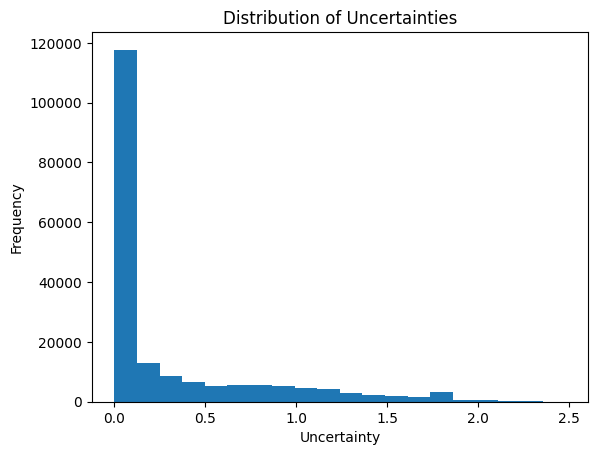

In [38]:

class LinearClassifierWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.01):
        super(LinearClassifierWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout with probability dropout_prob
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout with probability dropout_prob
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout during forward pass
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout during forward pass
        x = self.fc3(x)
        return x

model_dropout = LinearClassifierWithDropout(input_size=X_tensor.shape[1], hidden_size=100, num_classes=14, dropout_prob=0.01)
criterion_drop = nn.CrossEntropyLoss()  # Cross-entropy loss for classification  task
optimizer_drop = optim.Adam(model_dropout.parameters(), lr=0.003)
dataloader_drop = DataLoader(dataset, batch_size=32, shuffle=True)


# We train the model with dropout_prob=0
train(model_dropout, dataloader_drop, criterion_drop, optimizer_drop, num_epochs=10)

# Then we set dropout_prob=0.3 for uncertainty analysis
model_dropout.dropout1.p = 0.3
model_dropout.dropout2.p = 0.3


uncertainties = uncertainty_analysis(model_dropout, dataloader)
print("Uncertainties:", uncertainties)

uncertainties=np.nan_to_num(uncertainties)

visualize_uncertainties(uncertainties)

Final model trained on whole set: (Preprocessing)

In [41]:

X_all=X.to_numpy()
nan_indices = np.isnan(X_all)
num_nans = np.sum(nan_indices)

print("Number of NaN values:", num_nans)
column_means = np.nanmean(X_all, axis=0)

# We replace NaN values with column means
X_all[nan_indices] = np.take(column_means, np.where(nan_indices)[1])
nan_indices = np.isnan(X_all)
num_nans = np.sum(nan_indices)
print("Number of NaN values:", num_nans)

Number of NaN values: 0
Number of NaN values: 0


In [45]:
Y_all=y_encoded

X_tensor_all = torch.tensor(X_all, dtype=torch.float32)
Y_tensor_all = torch.tensor(Y_all, dtype=torch.long)  

# Create DataLoader
dataset = TensorDataset(X_tensor_all, Y_tensor_all)
dataloader_final = DataLoader(dataset, batch_size=final_batch_size, shuffle=True)

model_final = LinearClassifier(input_size=X_tensor.shape[1], hidden_size=final_hidden_size, num_classes=14)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer_final = optim.Adam(model_final.parameters(), lr=final_lr)

train(model_final, dataloader_final, criterion, optimizer_final, num_epochs=final_num_epochs)


Epoch 1/50, Loss: 0.8322, Accuracy: 0.7480
Epoch 2/50, Loss: 0.4712, Accuracy: 0.8524
Epoch 3/50, Loss: 0.4059, Accuracy: 0.8749
Epoch 4/50, Loss: 0.3822, Accuracy: 0.8836
Epoch 5/50, Loss: 0.3605, Accuracy: 0.8913
Epoch 6/50, Loss: 0.3861, Accuracy: 0.8921
Epoch 7/50, Loss: 0.3457, Accuracy: 0.8950
Epoch 8/50, Loss: 0.3316, Accuracy: 0.8997
Epoch 9/50, Loss: 0.3222, Accuracy: 0.9028
Epoch 10/50, Loss: 0.3198, Accuracy: 0.9036
Epoch 11/50, Loss: 0.3113, Accuracy: 0.9063
Epoch 12/50, Loss: 0.3115, Accuracy: 0.9066


KeyboardInterrupt: 

Testing model on the new input

In [ ]:
new_input='...'
new_ouput='...'

with torch.no_grad():
    outputs=model_final(new_input)
    print(outputs.shape)
    predictions_probabilities=torch.softmax(outputs,axis=1)
    #predictions_probabilities /= predictions_probabilities.sum(axis=1, keepdims=True)
    predictions_probabilities=predictions_probabilities.detach().numpy() 
    predictions=np.argmax(predictions_probabilities, axis=1)

accuracy = accuracy_score(new_ouput, predictions)
print("Accuracy:", accuracy)

macro_f1 = f1_score(new_ouput, predictions, average='macro')
print("Macro F1 score:", macro_f1)

auc = roc_auc_score(new_ouput, predictions_probabilities, multi_class='ovr')
print("AUC score (OvR):", auc)

average_precision = average_precision_score(new_ouput, predictions_probabilities)
print("Average Precision score:", average_precision)